This notebook is all about coming up with ways to asses how good a job PyVBMC does. 

To start, we'll state the differential equation of interest, get integration working for that equation, and run a PyVBMC optimize routine on it.


The differential equation:

$$\ddot{x} = -x -ax^b$$

generalized to deal with all values of b:

$$\ddot{x} = -x - sign(x)a|x|^b$$

$0<a\leq0.5$

 $1\leq b \leq 5$

In [195]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# import scipy.stats as scs
import scipy.integrate as integrate

import alphashape
from descartes import PolygonPatch
# import numpy as np
# import matplotlib.pyplot as plt

In [120]:
def diffyqs(X, t, a,b):
    x, vx = X[0], X[1]
    dx = vx
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dx, dv]

initial_condition = [0.0, 3.5]
t = np.arange(0,10,0.05)

a = 0.2
b = 2.0
sol = odeint(diffyqs, initial_condition, t, args=(a,b))
# u = 0.1
# v = 2.5
# sol2 = odeint(diffyqs, initial_condition, t, args=(u,v))

# x_true = sol[:,1]

a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

In [121]:
np.random.seed(3)
y = sol[:, 1]
# print(len(y))
changed = y + np.random.normal(0, .25, 200)
sol2 = np.ndarray((200,2))
for i in range(200):
    sol2[i, 0] = sol[i, 0]
    sol2[i, 1] = changed[i]
    if i == 0:
        sol2[i, 0] = sol[i, 0]
        sol2[i, 1] = 3.5

x_true = sol2[:,1]

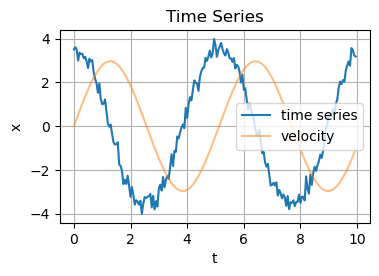

In [122]:
def plot_ts(t,ts,v, mode = 0):
    plt.figure(figsize=(4,2.5))
    if mode == 0:
        plt.plot(t,ts)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.grid()
        plt.show()
    else:
        plt.plot(t,ts, label = 'time series')
        plt.plot(t,v, label = 'velocity', alpha = 0.5)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend()
        plt.grid()
        plt.show()

plot_ts(t,sol2[:, 1],sol2[:, 0],1)
# plot_ts(t,sol2[:, 1],sol2[:, 0],1)

In [123]:
def log_likelihood(theta):
    a,b = theta

    sol = odeint(diffyqs, initial_condition, t, args=(a,b)) # get solution of ODE with current choice of params
    sigma = .25
    # return -np.sum((sol[:,1] - x_true)**2) # normal distribution sorta
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol[:,1] - x_true)**2)

In [124]:
D = 2  # 2-D since there are 2 params we're estimating

LB = np.full((1, D), a_min)  # Lower bounds
LB[0][1] = b_min
UB = np.full((1, D), a_max)  # Upper bounds
UB[0][1] = b_max

PLB = np.copy(LB) + 0.05
PUB = np.copy(UB) - 0.05

x0 = np.full((1, D), 0.11) # starting point for inference   # 1.5 * np.ones((1, D))
x0[0][1] = 3.5

print(LB,PLB,PUB,UB,'x0:',x0)

[[0. 1.]] [[0.05 1.05]] [[0.45 4.95]] [[0.5 5. ]] x0: [[0.11 3.5 ]]


In [125]:
prior1 = SplineTrapezoidal(LB, PLB, PUB, UB)

options1 = {
    "display": "off"
}

#vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) # initialize VMBC object

In [7]:
def euclidean_metric(vp,truth_array, n_samples = int(1e6)): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)
    """
    Xs, _ = vp.sample(n_samples) # sample vp
    # scaler = StandardScaler() # create scaler (don't bother centering)
    # scaler = MinMaxScaler(feature_range=(0,1))
    scaler = MinMaxScaler()
    scaler.fit(Xs)                     # fit scaler to samples
    scaled_data = scaler.transform(Xs) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    return np.linalg.norm(mean-truth_scaled) # return distance between mean and truth

# call the function on our current example
#euclidean_metric(vp,np.array([[a,b]]))

In [126]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior1, options = options1) # initialize VMBC object
np.random.seed(3)
vp, results = vbmc.optimize() # do optimization (might take a while)

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7.444 +/-0.001.


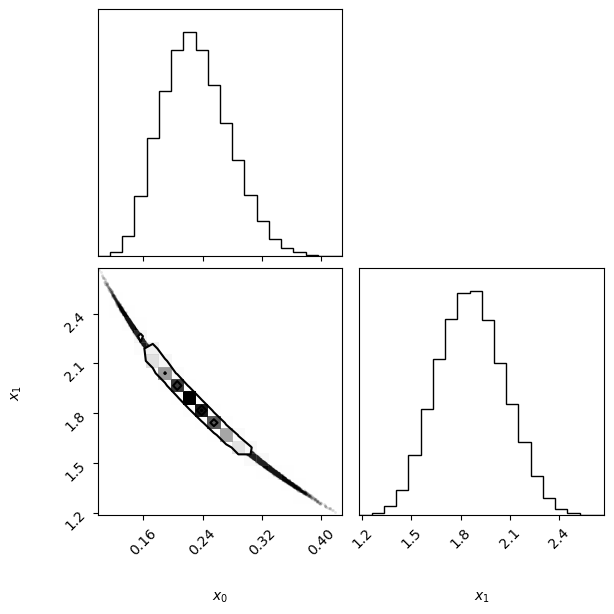

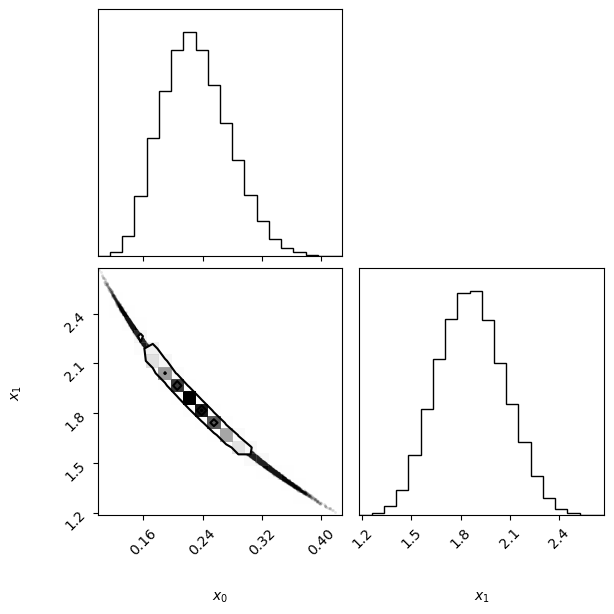

In [127]:
vp.plot()

In [128]:
np.random.seed(3)
vp.moments()
# vp.plot()

array([[0.23085474, 1.86652682]])

In [150]:
# Xs, _ = vp.sample(int(5e5))
# print(Xs[:,1])

xy = np.mgrid[0:.50001:0.0025, 1:5.00001:0.0025].reshape(2,-1).T
print(xy)


[[0.     1.    ]
 [0.     1.0025]
 [0.     1.005 ]
 ...
 [0.5    4.995 ]
 [0.5    4.9975]
 [0.5    5.    ]]


In [171]:
# pdf_simple = lambda x,y: vp.pdf(np.array([[x,y]]))
# print(pdf_simple(0,0))
def CI_2D_grid(vp,true_value,n_samples = int(3e5)):
    
    Xs, _ = vp.sample(n_samples)

    threshold = vp.pdf(true_value)

    pdfs = vp.pdf(Xs)

    high_threshold_samples = []

    for i in range(len(pdfs)):
        # print(i)
        if pdfs[i] >= threshold:
            # print(Xs[i])
            high_threshold_samples.append(Xs[i])
    
    indices = []

    xy = np.mgrid[0:.50001:0.0025, 1:5.00001:0.0025].reshape(2,-1).T

    new_xy = []
    for i in range(len(xy)):
        new = vp.pdf(xy[i])
        if new != [0.]:
            new_xy.append(xy[i])


    not_seen_xy = np.copy(new_xy)

    return not_seen_xy

np.savetxt("AHHHHHH", CI_2D_grid(vp, [0.2,2.0]))


In [200]:
Xs, _ = vp.sample(int(100))
print(type(Xs))
print(Xs)

<class 'numpy.ndarray'>
[[0.16731962 2.1800592 ]
 [0.30597124 1.56026748]
 [0.24800799 1.77221023]
 [0.37760317 1.31691712]
 [0.16635593 2.18483763]
 [0.30312151 1.57347668]
 [0.18650432 2.08003506]
 [0.23568812 1.81924939]
 [0.17019906 2.16023942]
 [0.2483126  1.77948658]
 [0.29996543 1.56986308]
 [0.14544598 2.31824462]
 [0.31322936 1.52339018]
 [0.26807362 1.68083548]
 [0.13452716 2.39529071]
 [0.2436621  1.77863398]
 [0.2320465  1.84720317]
 [0.25022484 1.75881235]
 [0.18990885 2.04938553]
 [0.23762367 1.82711372]
 [0.24348164 1.79624176]
 [0.28648496 1.62039546]
 [0.28418885 1.62639235]
 [0.15138428 2.28035996]
 [0.17433952 2.13974468]
 [0.25659734 1.73781025]
 [0.19572053 2.02891906]
 [0.26074208 1.70733476]
 [0.21707471 1.90778272]
 [0.23820229 1.80389583]
 [0.27792052 1.6439684 ]
 [0.22276796 1.89153286]
 [0.26883512 1.69210459]
 [0.20330628 1.9749735 ]
 [0.17205441 2.15587529]
 [0.21219472 1.93822509]
 [0.23019098 1.85526151]
 [0.19707316 2.0064417 ]
 [0.16461153 2.20304926]
 

In [191]:
# pdf_simple = lambda x,y: vp.pdf(np.array([[x,y]]))
# print(pdf_simple(0,0))
def CI_2D_grid(vp,true_value,n_samples = int(5e5)):

    Xs, _ = vp.sample(n_samples)

    threshold = vp.pdf(true_value)
    
    pdfs = vp.pdf(Xs)

    high_threshold_samples = []

    for i in range(len(pdfs)):
        # print(i)
        if pdfs[i] >= threshold:
            # print(Xs[i])
            high_threshold_samples.append(Xs[i])

    xy = np.mgrid[0:.50001:0.0025, 1:5.00001:0.0025].reshape(2,-1).T

    grid_pdfs = vp.pdf(xy)

    new_xy = []
    for i in range(len(grid_pdfs)): # removes all the grid points that don't have any samples within it
        # new = grid_pdfs[i]
        if grid_pdfs[i] != [0.]:
            new_xy.append(xy[i])

    not_seen_xy = np.copy(new_xy)

    return new_xy

    
np.savetxt("indices_try_faster", CI_2D_grid(vp, [0.2,2.0]))    

print(CI_2D_grid(vp, [0.2,2.0]))


[array([2.5000e-03, 4.2925e+00]), array([2.500e-03, 4.295e+00]), array([2.5000e-03, 4.2975e+00]), array([2.5e-03, 4.3e+00]), array([2.5000e-03, 4.3025e+00]), array([2.500e-03, 4.305e+00]), array([2.5000e-03, 4.3075e+00]), array([2.50e-03, 4.31e+00]), array([2.5000e-03, 4.3125e+00]), array([2.500e-03, 4.315e+00]), array([2.5000e-03, 4.3175e+00]), array([2.50e-03, 4.32e+00]), array([2.5000e-03, 4.3225e+00]), array([2.500e-03, 4.325e+00]), array([2.5000e-03, 4.3275e+00]), array([2.50e-03, 4.33e+00]), array([2.5000e-03, 4.3325e+00]), array([2.500e-03, 4.335e+00]), array([2.5000e-03, 4.3375e+00]), array([2.50e-03, 4.34e+00]), array([2.5000e-03, 4.3425e+00]), array([2.500e-03, 4.345e+00]), array([2.5000e-03, 4.3475e+00]), array([2.50e-03, 4.35e+00]), array([2.5000e-03, 4.3525e+00]), array([2.500e-03, 4.355e+00]), array([2.5000e-03, 4.3575e+00]), array([2.50e-03, 4.36e+00]), array([2.5000e-03, 4.3625e+00]), array([2.500e-03, 4.365e+00]), array([2.5000e-03, 4.3675e+00]), array([2.50e-03, 4.37e

In [196]:
def turning_csv(filename):

    with open(filename) as file:
        # tracts = {}
        points = []
        for line in file:
            line_list = line.split(',')
            points.append([float(line_list[0].replace('\ufeff','')), float(line_list[1].replace('\n',''))])
            # print(line_list)
    return points

In [198]:
points = turning_csv('/Users/gracerojo/Downloads/REU/hull_dat_try1.csv')
print(points)

[[0.25540677, 1.742462639], [0.255401124, 1.742582259], [0.255388886, 1.742730301], [0.255385192, 1.742746633], [0.255286572, 1.743102479], [0.25530114, 1.743276103], [0.255245281, 1.743431387], [0.255189634, 1.743546804], [0.255232111, 1.743712592], [0.255168258, 1.743832763], [0.255124369, 1.743892784], [0.254973332, 1.744058747], [0.255053391, 1.744149365], [0.25511433, 1.744337284], [0.255065091, 1.74450037], [0.254925731, 1.744683577], [0.254986521, 1.744738734], [0.254985501, 1.744980018], [0.254938459, 1.745135526], [0.254911919, 1.74529798], [0.254894437, 1.745362795], [0.254861441, 1.745533094], [0.2548407, 1.745671626], [0.254799234, 1.745867183], [0.25477907, 1.745914118], [0.25477031, 1.745922197], [0.254704411, 1.746079634], [0.254710762, 1.746199352], [0.254647839, 1.746391266], [0.25464553, 1.746471319], [0.254598898, 1.746568025], [0.254506975, 1.746682586], [0.254594584, 1.746760639], [0.254561601, 1.746914354], [0.254561545, 1.746987058], [0.254548753, 1.747080108], [

In [179]:
indices = [array([0.1925, 2.0275]), array([0.1925, 2.03  ]), array([0.1925, 2.0325]), array([0.195, 2.015]), array([0.195 , 2.0175]), array([0.195, 2.02 ]), array([0.195 , 2.0225]), array([0.195, 2.025]), array([0.195 , 2.0275]), array([0.195, 2.03 ]), array([0.1975, 2.    ]), array([0.1975, 2.0025]), array([0.1975, 2.005 ]), array([0.1975, 2.0075]), array([0.1975, 2.01  ]), array([0.1975, 2.0125]), array([0.1975, 2.015 ]), array([0.1975, 2.0175]), array([0.2   , 1.9875]), array([0.2 , 1.99]), array([0.2   , 1.9925]), array([0.2  , 1.995]), array([0.2   , 1.9975]), array([0.2, 2. ]), array([0.2   , 2.0025]), array([0.2  , 2.005]), array([0.2025, 1.975 ]), array([0.2025, 1.9775]), array([0.2025, 1.98  ]), array([0.2025, 1.9825]), array([0.2025, 1.985 ]), array([0.2025, 1.9875]), array([0.2025, 1.99  ]), array([0.2025, 1.9925]), array([0.205 , 1.9625]), array([0.205, 1.965]), array([0.205 , 1.9675]), array([0.205, 1.97 ]), array([0.205 , 1.9725]), array([0.205, 1.975]), array([0.205 , 1.9775]), array([0.205, 1.98 ]), array([0.205 , 1.9825]), array([0.2075, 1.95  ]), array([0.2075, 1.9525]), array([0.2075, 1.955 ]), array([0.2075, 1.9575]), array([0.2075, 1.96  ]), array([0.2075, 1.9625]), array([0.2075, 1.965 ]), array([0.2075, 1.9675]), array([0.2075, 1.97  ]), array([0.21  , 1.9375]), array([0.21, 1.94]), array([0.21  , 1.9425]), array([0.21 , 1.945]), array([0.21  , 1.9475]), array([0.21, 1.95]), array([0.21  , 1.9525]), array([0.21 , 1.955]), array([0.21  , 1.9575]), array([0.2125, 1.925 ]), array([0.2125, 1.9275]), array([0.2125, 1.93  ]), array([0.2125, 1.9325]), array([0.2125, 1.935 ]), array([0.2125, 1.9375]), array([0.2125, 1.94  ]), array([0.2125, 1.9425]), array([0.2125, 1.945 ]), array([0.215 , 1.9125]), array([0.215, 1.915]), array([0.215 , 1.9175]), array([0.215, 1.92 ]), array([0.215 , 1.9225]), array([0.215, 1.925]), array([0.215 , 1.9275]), array([0.215, 1.93 ]), array([0.215 , 1.9325]), array([0.2175, 1.9   ]), array([0.2175, 1.9025]), array([0.2175, 1.905 ]), array([0.2175, 1.9075]), array([0.2175, 1.91  ]), array([0.2175, 1.9125]), array([0.2175, 1.915 ]), array([0.2175, 1.9175]), array([0.2175, 1.92  ]), array([0.22  , 1.8875]), array([0.22, 1.89]), array([0.22  , 1.8925]), array([0.22 , 1.895]), array([0.22  , 1.8975]), array([0.22, 1.9 ]), array([0.22  , 1.9025]), array([0.22 , 1.905]), array([0.22  , 1.9075]), array([0.22, 1.91]), array([0.2225, 1.8775]), array([0.2225, 1.88  ]), array([0.2225, 1.8825]), array([0.2225, 1.885 ]), array([0.2225, 1.8875]), array([0.2225, 1.89  ]), array([0.2225, 1.8925]), array([0.2225, 1.895 ]), array([0.2225, 1.8975]), array([0.225, 1.865]), array([0.225 , 1.8675]), array([0.225, 1.87 ]), array([0.225 , 1.8725]), array([0.225, 1.875]), array([0.225 , 1.8775]), array([0.225, 1.88 ]), array([0.225 , 1.8825]), array([0.225, 1.885]), array([0.2275, 1.855 ]), array([0.2275, 1.8575]), array([0.2275, 1.86  ]), array([0.2275, 1.8625]), array([0.2275, 1.865 ]), array([0.2275, 1.8675]), array([0.2275, 1.87  ]), array([0.2275, 1.8725]), array([0.2275, 1.875 ]), array([0.23  , 1.8425]), array([0.23 , 1.845]), array([0.23  , 1.8475]), array([0.23, 1.85]), array([0.23  , 1.8525]), array([0.23 , 1.855]), array([0.23  , 1.8575]), array([0.23, 1.86]), array([0.23  , 1.8625]), array([0.2325, 1.8325]), array([0.2325, 1.835 ]), array([0.2325, 1.8375]), array([0.2325, 1.84  ]), array([0.2325, 1.8425]), array([0.2325, 1.845 ]), array([0.2325, 1.8475]), array([0.2325, 1.85  ]), array([0.235, 1.82 ]), array([0.235 , 1.8225]), array([0.235, 1.825]), array([0.235 , 1.8275]), array([0.235, 1.83 ]), array([0.235 , 1.8325]), array([0.235, 1.835]), array([0.235 , 1.8375]), array([0.235, 1.84 ]), array([0.2375, 1.81  ]), array([0.2375, 1.8125]), array([0.2375, 1.815 ]), array([0.2375, 1.8175]), array([0.2375, 1.82  ]), array([0.2375, 1.8225]), array([0.2375, 1.825 ]), array([0.2375, 1.8275]), array([0.24, 1.8 ]), array([0.24  , 1.8025]), array([0.24 , 1.805]), array([0.24  , 1.8075]), array([0.24, 1.81]), array([0.24  , 1.8125]), array([0.24 , 1.815]), array([0.24  , 1.8175]), array([0.2425, 1.79  ]), array([0.2425, 1.7925]), array([0.2425, 1.795 ]), array([0.2425, 1.7975]), array([0.2425, 1.8   ]), array([0.2425, 1.8025]), array([0.2425, 1.805 ]), array([0.245 , 1.7775]), array([0.245, 1.78 ]), array([0.245 , 1.7825]), array([0.245, 1.785]), array([0.245 , 1.7875]), array([0.245, 1.79 ]), array([0.245 , 1.7925]), array([0.245, 1.795]), array([0.2475, 1.7675]), array([0.2475, 1.77  ]), array([0.2475, 1.7725]), array([0.2475, 1.775 ]), array([0.2475, 1.7775]), array([0.2475, 1.78  ]), array([0.2475, 1.7825]), array([0.2475, 1.785 ]), array([0.25  , 1.7575]), array([0.25, 1.76]), array([0.25  , 1.7625]), array([0.25 , 1.765]), array([0.25  , 1.7675]), array([0.25, 1.77]), array([0.25  , 1.7725]), array([0.2525, 1.7475]), array([0.2525, 1.75  ]), array([0.2525, 1.7525]), array([0.2525, 1.755 ]), array([0.2525, 1.7575]), array([0.2525, 1.76  ]), array([0.2525, 1.7625]), array([0.255 , 1.7425]), array([0.255, 1.745]), array([0.255 , 1.7475]), array([0.255, 1.75 ])]

print(type(indices))

NameError: name 'array' is not defined

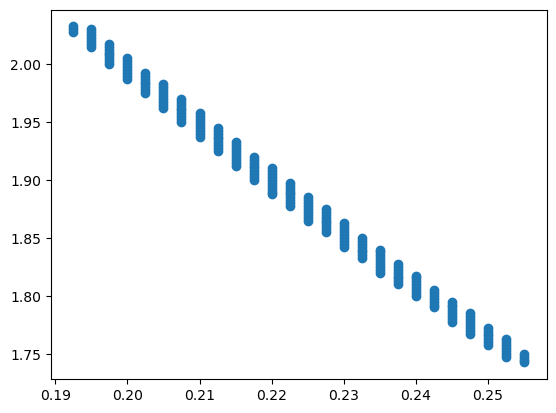

In [178]:

points = [[0.1925, 2.0275], [0.1925, 2.03], [0.1925, 2.0325], [0.195, 2.015], [0.195, 2.0175], [0.195, 2.02], [0.195, 2.0225], [0.195, 2.025], [0.195, 2.0275], [0.195, 2.03], [0.1975, 2.], [0.1975, 2.0025], [0.1975, 2.005], [0.1975, 2.0075], [0.1975, 2.01], [0.1975, 2.0125], [0.1975, 2.015], [0.1975, 2.0175], [0.2, 1.9875], [0.2, 1.99], [0.2, 1.9925], [0.2, 1.995], [0.2, 1.9975], [0.2, 2.], [0.2, 2.0025], [0.2, 2.005], [0.2025, 1.975], [0.2025, 1.9775], [0.2025, 1.98], [0.2025, 1.9825], [0.2025, 1.985], [0.2025, 1.9875], [0.2025, 1.99], [0.2025, 1.9925], [0.205, 1.9625], [0.205, 1.965], [0.205, 1.9675], [0.205, 1.97], [0.205, 1.9725], [0.205, 1.975], [0.205, 1.9775], [0.205, 1.98], [0.205, 1.9825], [0.2075, 1.95], [0.2075, 1.9525], [0.2075, 1.955], [0.2075, 1.9575], [0.2075, 1.96], [0.2075, 1.9625], [0.2075, 1.965], [0.2075, 1.9675], [0.2075, 1.97], [0.21, 1.9375], [0.21, 1.94], [0.21, 1.9425], [0.21, 1.945], [0.21, 1.9475], [0.21, 1.95], [0.21, 1.9525], [0.21, 1.955], [0.21, 1.9575], [0.2125, 1.925], [0.2125, 1.9275], [0.2125, 1.93], [0.2125, 1.9325], [0.2125, 1.935], [0.2125, 1.9375], [0.2125, 1.94], [0.2125, 1.9425], [0.2125, 1.945], [0.215, 1.9125], [0.215, 1.915], [0.215, 1.9175], [0.215, 1.92], [0.215, 1.9225], [0.215, 1.925], [0.215, 1.9275], [0.215, 1.93], [0.215, 1.9325], [0.2175, 1.9], [0.2175, 1.9025], [0.2175, 1.905], [0.2175, 1.9075], [0.2175, 1.91], [0.2175, 1.9125], [0.2175, 1.915], [0.2175, 1.9175], [0.2175, 1.92], [0.22, 1.8875], [0.22, 1.89], [0.22, 1.8925], [0.22, 1.895], [0.22, 1.8975], [0.22, 1.9], [0.22, 1.9025], [0.22, 1.905], [0.22, 1.9075], [0.22, 1.91], [0.2225, 1.8775], [0.2225, 1.88], [0.2225, 1.8825], [0.2225, 1.885], [0.2225, 1.8875], [0.2225, 1.89], [0.2225, 1.8925], [0.2225, 1.895], [0.2225, 1.8975], [0.225, 1.865], [0.225, 1.8675], [0.225, 1.87], [0.225, 1.8725], [0.225, 1.875], [0.225, 1.8775], [0.225, 1.88], [0.225, 1.8825], [0.225, 1.885], [0.2275, 1.855], [0.2275, 1.8575], [0.2275, 1.86], [0.2275, 1.8625], [0.2275, 1.865], [0.2275, 1.8675], [0.2275, 1.87], [0.2275, 1.8725], [0.2275, 1.875], [0.23, 1.8425], [0.23, 1.845], [0.23, 1.8475], [0.23, 1.85], [0.23, 1.8525], [0.23, 1.855], [0.23, 1.8575], [0.23, 1.86], [0.23, 1.8625], [0.2325, 1.8325], [0.2325, 1.835], [0.2325, 1.8375], [0.2325, 1.84], [0.2325, 1.8425], [0.2325, 1.845], [0.2325, 1.8475], [0.2325, 1.85], [0.235, 1.82], [0.235, 1.8225], [0.235, 1.825], [0.235, 1.8275], [0.235, 1.83], [0.235, 1.8325], [0.235, 1.835], [0.235, 1.8375], [0.235, 1.84], [0.2375, 1.81], [0.2375, 1.8125], [0.2375, 1.815], [0.2375, 1.8175], [0.2375, 1.82], [0.2375, 1.8225], [0.2375, 1.825], [0.2375, 1.8275], [0.24, 1.8], [0.24, 1.8025], [0.24, 1.805], [0.24, 1.8075], [0.24, 1.81], [0.24, 1.8125], [0.24, 1.815], [0.24, 1.8175], [0.2425, 1.79], [0.2425, 1.7925], [0.2425, 1.795], [0.2425, 1.7975], [0.2425, 1.8], [0.2425, 1.8025], [0.2425, 1.805], [0.245, 1.7775], [0.245, 1.78], [0.245, 1.7825], [0.245, 1.785], [0.245, 1.7875], [0.245, 1.79], [0.245, 1.7925], [0.245, 1.795], [0.2475, 1.7675], [0.2475, 1.77], [0.2475, 1.7725], [0.2475, 1.775], [0.2475, 1.7775], [0.2475, 1.78], [0.2475, 1.7825], [0.2475, 1.785], [0.25, 1.7575], [0.25, 1.76], [0.25, 1.7625], [0.25, 1.765], [0.25, 1.7675], [0.25, 1.77], [0.25, 1.7725], [0.2525, 1.7475], [0.2525, 1.75], [0.2525, 1.7525], [0.2525, 1.755], [0.2525, 1.7575], [0.2525, 1.76], [0.2525, 1.7625], [0.255, 1.7425], [0.255, 1.745], [0.255, 1.7475], [0.255, 1.75]]
# print(points[:,0])
x_list = []
y_list = []

for i in range(len(points)):
    x_list.append(points[i][0])
    y_list.append(points[i][1])

x_array = np.array(x_list)
y_array = np.array(y_list)

# print(len(points))

plt.scatter(x_array, y_array)

for i in points:
    

In [53]:
# NOPE
np.random.seed(3)
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)
df = pd.DataFrame(Xs, columns= ['a', 'b'])
df.to_csv("Xs_data_try1")

In [57]:
np.random.seed(3)
n_samples = int(5e4)
Xs, _ = vp.sample(n_samples) # sample vp

# print(Xs)
# print(Xs[:,0])
range_small = [min(Xs[:,0]), max(Xs[:,0])]
range_large = [min(Xs[:,1]), max(Xs[:,1])]
# print(range_small, range_large)

# print(np.linspace(range_small[0] - .00000001, range_small[1], 10000))
# print(np.linspace(range_large[0] - .0000001, range_large[1], 10000))


intervals_small = np.linspace(range_small[0] - .00000001, range_small[1], 10000)
intervals_large = np.linspace(range_large[0] - .0000001, range_large[1], 10000)

print(intervals_large[101] - intervals_large[100])
print(intervals_large[102] - intervals_large[101])
print(intervals_large[103] - intervals_large[102])
print(intervals_large[104] - intervals_large[103])


0.00022465352436551456
0.00022465352436551456
0.00022465352436551456
0.00022465352436551456


In [55]:
np.random.seed(0)
n_samples = int(5e4)
Xs, _ = vp.sample(n_samples) # sample vp

range_small = [min(Xs[:,0]), max(Xs[:,0])]
range_large = [min(Xs[:,1]), max(Xs[:,1])]


intervals_small = np.linspace(range_small[0] - .00000001, range_small[1], 10000)
intervals_large = np.linspace(range_large[0] - .0000001, range_large[1], 10000)


final_sets_small = []
final_sets_large = []

final_sets = []



# print(Xs[10,0])
for i in range(len(Xs) - 1):
    new_small = 0
    new_large = 0
    for j in range(len(intervals_small) - 1):
        if intervals_small[j] <= Xs[i,0] < intervals_small[j+1]:
            # final_sets_small.append(j)
            new_small = intervals_small[j]
            # final_sets.append([])
        if intervals_large[j] <= Xs[i,1] < intervals_large[j+1]:
            # final_sets_large.append(j)
            new_large = intervals_large[j]
    final_sets.append([new_small, new_large])
        
pdf_mode = scs.mode(final_sets, keepdims = True)[0]
print("mode:",pdf_mode)

mode: [[0.21015107 1.77376373]]


In [104]:
np.random.seed(0)

pdf_simple = lambda x,y: vp.pdf(np.array([[y,x]]))
def CI_2D(vp,pdf,true_value,step = 0.05,n_samples = int(5e5)):
    # do sampling, take mode of samples
    Xs, _ = vp.sample(n_samples) # sample vp
    # pdf_mode = scs.mode(Xs,keepdims = True)[0]
    # pdf_mode = [[0.21015107, 1.77376373]]
    pdf_mode = [[0.24060893, 1.89540036]]
    pdf_mode = vp.moments()
    print("mode:",pdf_mode)
    a0,b0 = pdf_mode[0][0] - step, pdf_mode[0][0] + step
    a1,b1 = pdf_mode[0][1] - step, pdf_mode[0][1] + step
    print("a0, b0:", a0, b0, "a1, b1:", a1, b1)
    I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
    print(I)
    print(true_value)
    def check_if_in_CI(true_value,a0,b0,a1,b1):
        # if a0 <= true_value[0] and true_value[0] <= b0 \
        #     and a1 <= true_value[1] and true_value[1] <= b1:

        if a0 <= true_value[0] <= b0 and a1 <= true_value[1] <= b1:
            print("hit")
            # I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
            return False
        else:
            return True
    iter = 0
    while check_if_in_CI(true_value,a0,b0,a1,b1):
        # I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
        a0 -= step
        b0 += step
        a1 -= step
        b1 += step
        #print("iter",iter )
        iter += 1
        print(I)
    I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
    return I
print("CI:",CI_2D(vp,pdf_simple,[0.2,2.0],0.1))


mode: [[0.24060893, 1.89540036]]
a0, b0: 0.14060893 0.34060893000000003 a1, b1: 1.79540036 1.99540036
0.1501811568014279
[0.2, 2.0]
0.1501811568014279
hit
CI: 0.2966372699180154


In [81]:
# [[0.24060893, 1.89540036]]
np.random.seed(3)

pdf_simple = lambda x,y: vp.pdf(np.array([[y,x]]))
def CI_2D(vp,pdf,true_value,step = 0.05,n_samples = int(5e5)):
    # do sampling, take mode of samples
    Xs, _ = vp.sample(n_samples) # sample vp
    # pdf_mode = scs.mode(Xs,keepdims = True)[0]
    pdf_mode = [[0.24060893, 1.89540036]]
    print("mode:",pdf_mode)
    a0,b0 = pdf_mode[0][0] - step, pdf_mode[0][0] + step
    a1,b1 = pdf_mode[0][1] - step, pdf_mode[0][1] + step
    print("a0, b0:", a0, b0, "a1, b1:", a1, b1)
    I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
    print(I)
    print(true_value)
    def check_if_in_CI(true_value,a0,b0,a1,b1):
        # if a0 <= true_value[0] and true_value[0] <= b0 \
        #     and a1 <= true_value[1] and true_value[1] <= b1:

        if a0 <= true_value[0] <= b0 and a1 <= true_value[1] <= b1:
            print("hit")
            # I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
            return False
        else:
            return True
    iter = 0
    while check_if_in_CI(true_value,a0,b0,a1,b1):
        # I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
        a0 -= step
        b0 += step
        a1 -= step
        b1 += step
        #print("iter",iter )
        iter += 1
        print(I)
    I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
    return I
print("CI:",CI_2D(vp,pdf_simple,[0.2,2.0],0.1))


mode: [[0.24060893, 1.89540036]]
a0, b0: 0.14060893 0.34060893000000003 a1, b1: 1.79540036 1.99540036


KeyboardInterrupt: 

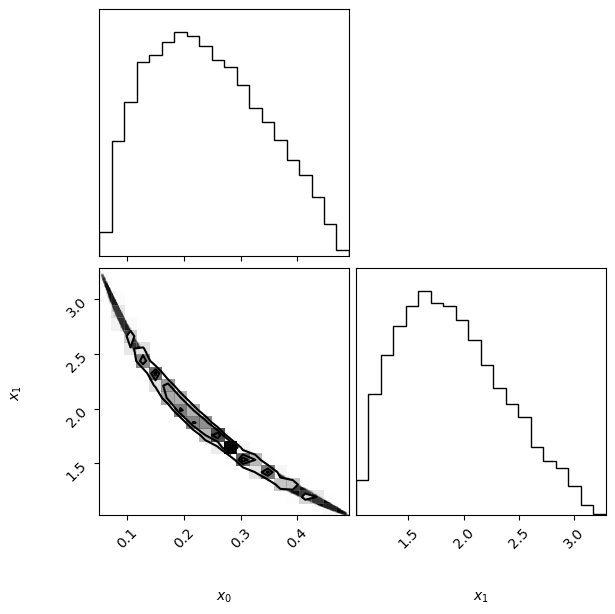

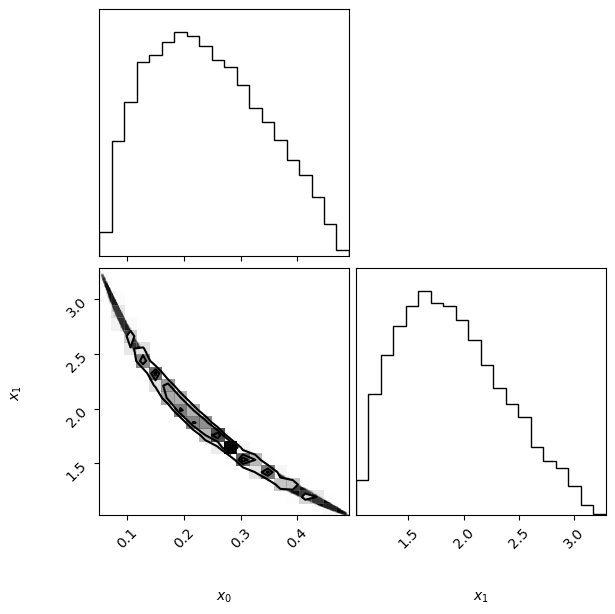

In [63]:
vp.plot()

In [91]:
# np.meshgrid()
# xv, yv = np.meshgrid(x, y, indexing='ij')


# nx, ny = (100, 100)
# x_coord = np.linspace(0, .5, nx)
# y_coord = np.linspace(1, 5, ny)
# xv, yv = np.meshgrid(x_coord, y_coord)
# print(xv)
# print(yv)

# plt.plot(xv, yv, marker='o', color='k', linestyle='none')
# plt.show()

# pdf_simple = lambda x,y: vp.pdf(np.array([[y,x]]))

pdf_simple = lambda x,y: vp.pdf(np.array([[x,y]]))
def CI_2D_grid(vp,pdf,true_value,n_samples = int(5e5)):
    nx, ny = (50, 200)
    x_coord = np.linspace(0, .5, nx)
    y_coord = np.linspace(1, 5, ny)
    # xv, yv = np.meshgrid(x_coord, y_coord)
    # threshold = pdf(true_value[0], true_value[1])
    threshold = np.log(pdf(true_value[0], true_value[1]))

    # moment = vp.moments()
    # threshold2 = pdf(vp.moments()[0][0], vp.moments()[0][1])
    threshold2 = np.log(pdf(vp.moments()[0][0], vp.moments()[0][1]))
    indices_list = []
    largest_threshold = 0
    for i in range(len(x_coord)-1):
        x_val = (x_coord[i] + x_coord[i+1])/2
        for j in range(len(y_coord)-1):
            y_val = (y_coord[i] + y_coord[i+1])/2
            if pdf(y_val, x_val) >= largest_threshold:
                # largest_threshold = pdf(x_val, y_val)
                largest_threshold = np.log(pdf(x_val, y_val))
            # if pdf(y_val, x_val) >= threshold:
            #     indices_list.append([x_coord[i], x_coord[i+1], y_coord[i], y_coord[i+1]])
    
    return largest_threshold, threshold, threshold2
    # return(len(indices_list),indices_list)

    # return xv[0]

print(CI_2D_grid(vp, pdf_simple, [0.2,2.0]))


/var/folders/w7/05l43x_n3_961q005lwk1dv40000gp/T/ipykernel_6369/1813657400.py:37: RuntimeWarning: divide by zero encountered in log
  largest_threshold = np.log(pdf(x_val, y_val))


(array([[2.73446705]]), array([[4.31883137]]), array([[-3.973463]]))


In [86]:
nx, ny = (10, 10)
x_coord = np.linspace(0, .5, nx)
y_coord = np.linspace(1, 5, ny)
xv, yv = np.meshgrid(x_coord, y_coord)
print(x_coord)
print(y_coord)

[0.         0.05555556 0.11111111 0.16666667 0.22222222 0.27777778
 0.33333333 0.38888889 0.44444444 0.5       ]
[1.         1.44444444 1.88888889 2.33333333 2.77777778 3.22222222
 3.66666667 4.11111111 4.55555556 5.        ]
